# Analysis using data with similar number of binary variables

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, kendalltau, zscore
from cliffs_delta import cliffs_delta
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="Greys")

In [41]:
data = pd.read_csv("../data/bias_symptoms_logreg_reduced.csv", index_col=[0,1])

In [42]:
def remove_outliers(data):
  data_new = data.reset_index()
  high_data = data_new.groupby("data").count()
  high_data[high_data['variable'] < high_data['variable'].quantile(0.75)]
  data_new = data_new[data_new["data"].isin(high_data[high_data["variable"] < high_data["variable"].quantile(0.75)].index)]
  data_new.drop(columns=["data", "variable"], inplace=True)
  sp = data_new.pop("statistical_parity")
  eo = data_new.pop("equal_opportunity")
  ao = data_new.pop("average_odds")

  data_new.insert(len(data_new.columns), "statistical_parity", sp)
  data_new.insert(len(data_new.columns), "equal_opportunity", eo)
  data_new.insert(len(data_new.columns), "average_odds", ao)
  return data_new

In [43]:
data.groupby(data.index.get_level_values(0)).count()

,correlation_true,mutual_info,unpriv_prob_pos,unpriv_unbalance,priv_unbalance,statistical_parity,equal_opportunity,average_odds,skew_var,gini,simpson,shannon,ir,pos_prob
data,,,,,,,,,,,,,,
adult,902,902,902,902,902,902,902,902,902,902,902,902,902,902
arrhythmia,318,318,318,318,318,318,318,318,318,318,318,318,318,318
bank,440,440,440,440,440,440,440,440,440,440,440,440,440,440
cmc,30,30,30,30,30,30,30,30,30,30,30,30,30,30
compas,1371,1371,1371,1371,1371,1371,1371,1371,1371,1371,1371,1371,1371,1371
credit,10,10,10,10,10,10,10,10,10,10,10,10,10,10
crime,21,21,21,21,21,21,21,21,21,21,21,21,21,21
diabetic,709,709,709,709,709,709,709,709,709,709,709,709,709,709
drug,20,20,20,20,20,20,20,20,20,20,20,20,20,20


## Correlation Analysis

In [44]:
data_new = remove_outliers(data)
kendall = data_new.corr("spearman").round(3)

for col in kendall.columns:
    for col2 in kendall.columns:
        pval = kendalltau(data[col], data[col2])[1]
        if pval > 0.05:
            kendall.loc[col, col2] = f"{kendall.loc[col, col2]}*"


upper = kendall.where(np.triu(np.ones(kendall.shape), k=1).astype(bool))
upper

,correlation_true,mutual_info,unpriv_prob_pos,unpriv_unbalance,priv_unbalance,skew_var,gini,simpson,shannon,ir,pos_prob,statistical_parity,equal_opportunity,average_odds
correlation_true,NaN,0.055*,0.026,-0.117,0.149,-0.058*,-0.047*,0.053,0.054,0.009*,0.108,0.122,0.041,-0.022*
mutual_info,NaN,NaN,-0.041,0.121,-0.065*,-0.189,-0.17,0.158,0.151,0.166,0.763,0.42,0.324,0.286
unpriv_prob_pos,NaN,NaN,NaN,0.246,-0.115*,-0.182,-0.124,0.526,0.534,0.203,0.128,-0.122,0.172,-0.046
unpriv_unbalance,NaN,NaN,NaN,NaN,-0.812,-0.097*,-0.036*,0.026,0.025,0.089,-0.003*,0.008*,0.016*,0.016
priv_unbalance,NaN,NaN,NaN,NaN,NaN,0.066,0.06,0.025,0.027,-0.078,0.008,-0.028,0.011*,-0.028
skew_var,NaN,NaN,NaN,NaN,NaN,NaN,0.952,-0.453,-0.445,-0.703,-0.038,-0.137,0.04,-0.096
gini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.429,-0.421,-0.659,-0.089,-0.193,0.059,-0.148
simpson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999,0.463,0.276,0.157*,0.105,0.095
shannon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.45,0.276,0.152*,0.107,0.095
ir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.06,0.019,-0.121,0.005


## Distribution of the data

In [45]:
data.shape

(5930, 14)

In [46]:
data = pd.read_csv("../data/bias_symptoms_logreg_reduced.csv", index_col=[0, 1])
data = remove_outliers(data)

In [47]:
def plot_differences(symps, symp, symp_name):
    corr_high_sp = symps[symps["statistical_parity"] == 1][symp].values
    corr_low_sp = symps[symps["statistical_parity"] == 0][symp].values
    corr_high_eo = symps[symps["equal_opportunity"] == 1][symp].values
    corr_low_eo = symps[symps["equal_opportunity"] == 0][symp].values
    corr_high_ao = symps[symps["average_odds"] == 1][symp].values
    corr_low_ao = symps[symps["average_odds"] == 0][symp].values
    df = pd.DataFrame(
        {
            symp_name: [
                corr_high_sp,
                corr_low_sp,
                corr_high_eo,
                corr_low_eo,
                corr_high_ao,
                corr_low_ao,
            ],
            "Metric": [
                "Statistical Parity",
                "Statistical Parity",
                "Equal Opportunity",
                "Equal Opportunity",
                "Average Odds",
                "Average Odds",
            ],
            "Bias": ["High", "Low", "High", "Low", "High", "Low"],
        }
    )
    df = df.explode(symp_name)
    g = sns.FacetGrid(df, col="Metric", height=4, aspect=1)
    g.map(
        sns.barplot,
        "Bias",
        symp_name,
        "Bias",
        order=["Low", "High"],
        hue_order=["Low", "High"],
        palette=sns.color_palette()[1:4:2],
    )
    g.set_titles("{col_name}")
    g.add_legend()
    # g.facet_axis(0,0).set_xlabel("T test pvalue: "+str(ttest_ind(corr_high_sp, corr_low_sp, equal_var=False)[1]))
    # g.facet_axis(0,1).set_xlabel("T test pvalue: "+str(ttest_ind(corr_high_eo, corr_low_eo, equal_var=False)[1]))
    # g.facet_axis(0,2).set_xlabel("T test pvalue: "+str(ttest_ind(corr_high_ao, corr_low_ao, equal_var=False)[1]))
    g.set_axis_labels("", symp_name)
    # plt.savefig(f"figs/{symp_name}.pdf", bbox_inches="tight")
    # plt.show()
    print(ttest_ind(corr_high_sp, corr_low_sp, equal_var=False))
    print(ttest_ind(corr_high_eo, corr_low_eo, equal_var=False))
    print(ttest_ind(corr_high_ao, corr_low_ao, equal_var=False))
    print(cliffs_delta(corr_high_sp, corr_low_sp))
    print(cliffs_delta(corr_high_eo, corr_low_eo))
    print(cliffs_delta(corr_high_ao, corr_low_ao))
    return g

### Analysis of Mutual Information

Ttest_indResult(statistic=10.856533112251517, pvalue=1.0708888103569397e-24)
Ttest_indResult(statistic=6.52793700689221, pvalue=1.3520571479099654e-10)
Ttest_indResult(statistic=6.832097726075935, pvalue=2.2253551826220012e-11)
(0.5733352499945096, 'large')
(0.40757464171132046, 'medium')
(0.38561263338202256, 'medium')


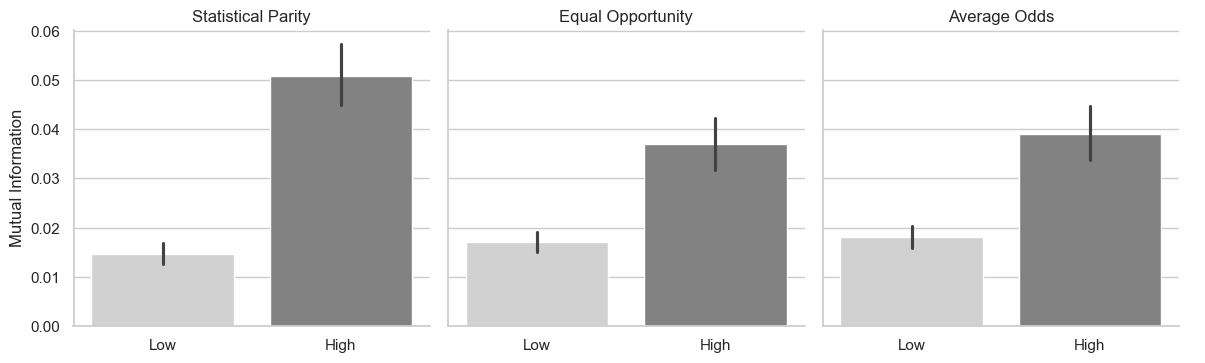

In [48]:
g = plot_differences(data, "mutual_info", "Mutual Information")
plt.show()

## Kendall's Tau

Ttest_indResult(statistic=3.854267852534621, pvalue=0.00013242267231034389)
Ttest_indResult(statistic=1.5798269273995997, pvalue=0.11459302949735396)
Ttest_indResult(statistic=0.5624840736382715, pvalue=0.5740234005032772)
(0.16582313609691918, 'small')
(0.051798427169836875, 'negligible')
(-0.029559626676991125, 'negligible')


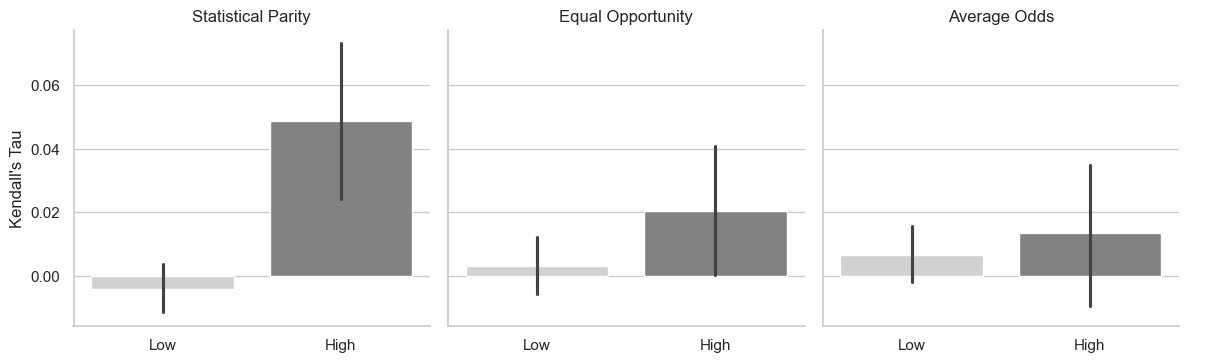

In [49]:
g = plot_differences(data, "correlation_true", "Kendall's Tau")
plt.show()

## Feature Importance

In [50]:
from sklearn.inspection import permutation_importance
import numpy as np
from scipy.stats import mannwhitneyu
from joblib import load

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier


labels = ["statistical_parity", "equal_opportunity", "average_odds"]
mlp = MLPClassifier(alpha=0.0001, hidden_layer_sizes=(50,), learning_rate='constant', learning_rate_init=0.01, max_iter=200)
rf = RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=1, min_samples_split=10, n_estimators=500)
xgb = XGBClassifier(colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=6, subsample=0.6)

In [52]:
def train_model(metric):
    mlp.fit(data.drop(columns=labels), data[metric])
    rf.fit(data.drop(columns=labels), data[metric])
    xgb.fit(data.drop(columns=labels), data[metric])
    return mlp, rf, xgb

In [53]:
def plot_importance(result):
    sorted_importances_idx = result['importances_mean'].argsort()
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=data.drop(columns=labels).columns[sorted_importances_idx],
    )
    fig, ax = plt.subplots(figsize=(2, 4))
    ax = importances.plot.box(vert=False, whis=10, color="black", ax=ax)
    #ax.axvline(x=0, color="k", linestyle="--")
    # ax.axhline(y=8.5, color="k", linestyle="--")
    ax.set_xlabel("AP Loss")
    return ax

def compute_statistical_difference(result):
    sorted_importances_idx = result["importances_mean"].argsort()
    importances = result.importances[sorted_importances_idx].T
    ris = []
    for i in range(importances.shape[1]):
        find = False
        for j in range(i + 1, importances.shape[1]):
                if not find:
                    test = mannwhitneyu(importances[:, i], importances[:, j])
                    if test[1] < 0.05:
                        print(
                            i+1, j+1,
                            # result["importances_mean"].index[sorted_importances_idx[i]],
                            # result["importances_mean"].index[sorted_importances_idx[j]],
                        )
                        find = True
                        ris.append((i+1, j+1))
    return ris

def compute_permutation(metric, xgb, rf, mlp):
    result_xgb = permutation_importance(
        xgb,
        data.drop(columns=labels),
        data[metric],
        scoring="average_precision",
        n_jobs=-1,
        n_repeats=10,
    )
    result_rf = permutation_importance(
        rf,
        data.drop(columns=labels),
        data[metric],
        scoring="average_precision",
        n_jobs=-1,
        n_repeats=10,
    )
    result_mlp = permutation_importance(
        mlp,
        data.drop(columns=labels),
        data[metric],
        scoring="average_precision",
        n_jobs=-1,
        n_repeats=10,
    )
    return result_xgb, result_rf, result_mlp

### Statistical Parity

In [54]:
mlp_sp, rf_sp, xgb_sp = train_model('statistical_parity')

In [55]:
result_xgb_sp, result_rf_sp, result_mlp_sp = compute_permutation('statistical_parity', xgb_sp, rf_sp, mlp_sp)

In [56]:
stats = compute_statistical_difference(result_xgb_sp)

1 2
2 4
3 4
4 7
5 7
6 7
7 8
8 9
9 10
10 11


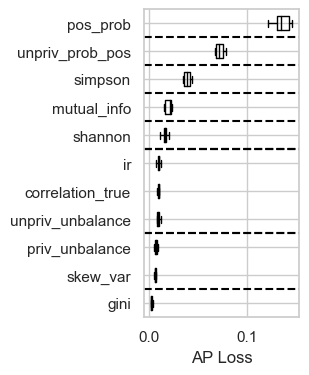

In [57]:
ax_xgb = plot_importance(result_xgb_sp)
# tick_labels = [
#         "Prob Diff",
#         "Simpson",
#         "UPP",
#         "Kurtosis",
#         "Mutual Info",
#         "Shannon",
#         "Kendall Tau",
#         "Unpriv Unbal",
#         "PPP",
#         "Priv Unbal",
#         "Skewness",
#         "Gini",
#         "IR",
#     ]
# tick_labels.reverse()
# ax_xgb.set_yticklabels(tick_labels)
for i, (a, b) in enumerate(stats):
    ax_xgb.axhline(y=b-0.5, color="k", linestyle="--")

In [58]:
stats_rf = compute_statistical_difference(result_rf_sp)

1 2
2 4
3 4
4 6
5 6
6 7
7 8
8 9
9 10
10 11


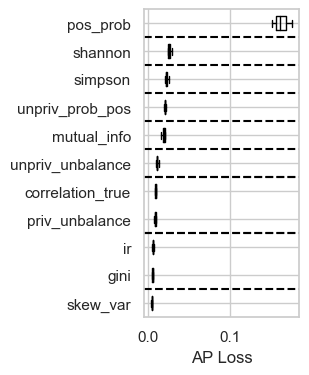

In [59]:
ax_rf = plot_importance(result_rf_sp)
for i, (a, b) in enumerate(stats_rf):
    ax_rf.axhline(y=b - 0.5, color="k", linestyle="--")
# tick_labels = [
#     "Prob Diff",
#     "UPP",
#     "Shannon",
#     "Mutual Info",
#     "Simpson",
#     "Kendall Tau",
#     "Kurtosis",
#     "IR",
#     "PPP",
#     "Skewness",
#     "Gini",
#     "Unpriv Unbal",
#     "Priv Unbal",
# ]
# tick_labels.reverse()
# ax_rf.set_yticklabels(tick_labels)
plt.show()

In [60]:
stats_mlp = compute_statistical_difference(result_mlp_sp)

1 2
2 3
3 4
4 5
5 7
6 7
7 8
8 9
9 10
10 11


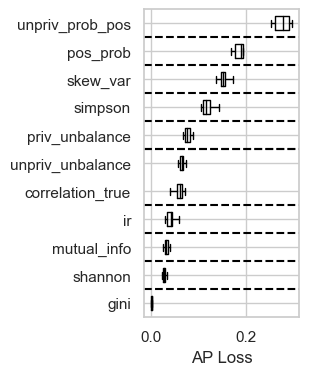

In [61]:
ax_mlp = plot_importance(result_mlp_sp)
for i, (a, b) in enumerate(stats_mlp):
    ax_mlp.axhline(y=b - 0.5, color="k", linestyle="--")
# tick_labels = [
#     "Kurtosis",
#     "Skewness",
#     "Prob Diff",
#     "PPP",
#     "Priv Unbal",
#     "UPP",
#     "Kendall Tau",
#     "Unpriv Unbal",
#     "IR",
#     "Simpson",
#     "Shannon",
#     "Mutual Info",
#     "Gini",
# ]
# tick_labels.reverse()
# ax_mlp.set_yticklabels(tick_labels)
plt.show()

## Equal Opportunity

In [78]:
mlp_eo, rf_eo, xgb_eo = train_model("equal_opportunity")

In [79]:
result_xgb_sp, result_rf_sp, result_mlp_sp = compute_permutation(
    "equal_opportunity", xgb_eo, rf_eo, mlp_eo
)

In [80]:
stats = compute_statistical_difference(result_xgb_sp)

1 2
2 5
3 5
4 5
5 6
6 7
7 9
8 9
9 10
10 11


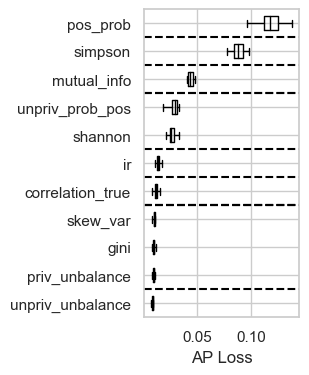

In [81]:
ax_xgb = plot_importance(result_xgb_sp)
# tick_labels = [
#         "Kurtosis",
#         "Simpson",
#         "Prob Diff",
#         "Mutual Info",
#         "Shannon",
#         "UPP",
#         "Kendall Tau",
#         "IR",
#         "PPP",
#         "Priv Unbal",
#         "Skewness",
#         "Unpriv Unbal",
#         "Gini",
#     ]
# tick_labels.reverse()
# ax_xgb.set_yticklabels(tick_labels)
for i, (a, b) in enumerate(stats):
    ax_xgb.axhline(y=b-0.5, color="k", linestyle="--")
plt.show()

In [82]:
stats_rf = compute_statistical_difference(result_rf_sp)

1 2
2 4
3 4
4 5
5 6
6 7
7 9
8 9
9 10
10 11


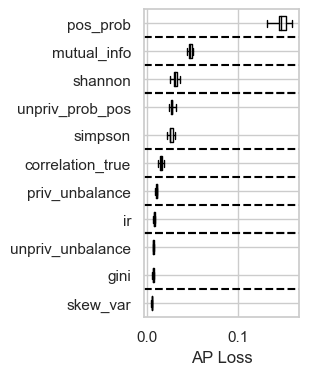

In [83]:
ax_rf = plot_importance(result_rf_sp)
for i, (a, b) in enumerate(stats_rf):
    ax_rf.axhline(y=b - 0.5, color="k", linestyle="--")
# tick_labels = [
#     "Prob Diff",
#     "Kurtosis",
#     "Shannon",
#     "Simpson",
#     "IR",
#     "Mutual Info",
#     "UPP",
#     "Gini",
#     "Kendall Tau",
#     "PPP",
#     "Skewness",
#     "Priv Unbal",
#     "Unpriv Unbal",
# ]
# tick_labels.reverse()
# ax_rf.set_yticklabels(tick_labels)
plt.show()

In [84]:
stats_mlp = compute_statistical_difference(result_mlp_sp)

1 2
2 4
3 4
4 7
5 7
6 7
7 8
8 9
9 11
10 11


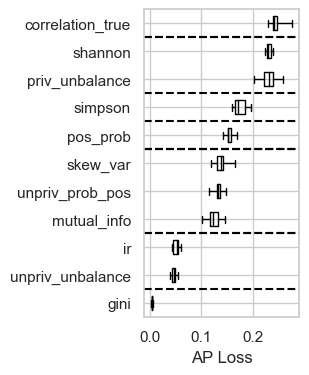

In [85]:
ax_mlp = plot_importance(result_mlp_sp)
for i, (a, b) in enumerate(stats_mlp):
    ax_mlp.axhline(y=b - 0.5, color="k", linestyle="--")
# tick_labels = [
#     "Kurtosis",
#     "Skewness",
#     "Prob Diff",
#     "Priv Unbal",
#     "UPP",
#     "PPP",
#     "Kendall Tau",
#     "Unpriv Unbal",
#     "Mutual Info",
#     "Simpson",
#     "Shannon",
#     "IR",
#     "Gini",
# ]
# tick_labels.reverse()
# ax_mlp.set_yticklabels(tick_labels)
plt.show()

## Average Odds

In [86]:
mlp_ao, rf_ao, xgb_ao = train_model("average_odds")

In [87]:
result_xgb_sp, result_rf_sp, result_mlp_sp = compute_permutation(
    "average_odds", xgb_ao, rf_ao, mlp_ao
)

In [88]:
stats = compute_statistical_difference(result_xgb_sp)

1 2
2 3
3 4
4 5
5 6
6 8
7 9
8 9
9 10
10 11


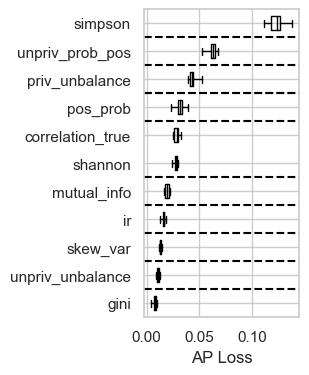

In [91]:
ax_xgb = plot_importance(result_xgb_sp)
# tick_labels = [
#         "Prob Diff",
#         "UPP",
#         "Simpson",
#         "Kendall Tau",
#         "Priv Unbal",
#         "Kurtosis",
#         "Shannon",
#         "Mutual Info",
#         "PPP",
#         "Unpriv Unbal",
#         "Skewness",
#         "Gini",
#         "IR",
#     ]
# tick_labels.reverse()
# ax_xgb.set_yticklabels(tick_labels)
for i, (a, b) in enumerate(stats):
    ax_xgb.axhline(y=b-0.5, color="k", linestyle="--")

plt.show()

In [93]:
stats_rf = compute_statistical_difference(result_rf_sp)

1 2
2 3
3 5
4 5
5 6
6 8
7 8
8 9
9 10


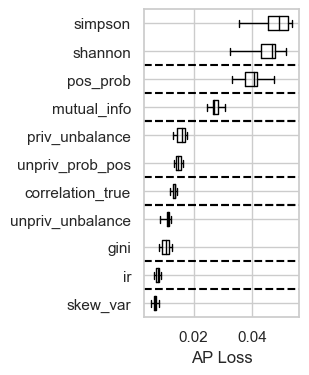

In [94]:
ax_rf = plot_importance(result_rf_sp)
for i, (a, b) in enumerate(stats_rf):
    ax_rf.axhline(y=b - 0.5, color="k", linestyle="--")
# tick_labels = [
#     "Prob Diff",
#     "UPP",
#     "Shannon",
#     "PPP",
#     "Simpson",
#     "Priv Unbal",
#     "Kendall Tau",
#     "Unpriv Unbal",
#     "Kurtosis",
#     "Mutual Info",
#     "IR",
#     "Gini",
#     "Skewness",
# ]
# tick_labels.reverse()
# ax_rf.set_yticklabels(tick_labels)
plt.show()

In [95]:
stats_mlp = compute_statistical_difference(result_mlp_sp)

1 2
2 3
3 5
4 6
5 6
6 7
7 9
8 9
9 10
10 11


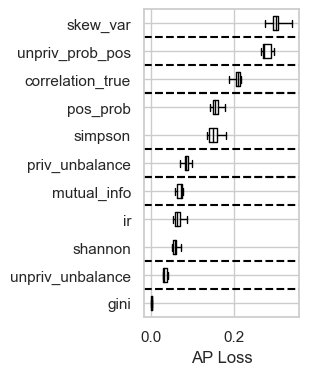

In [96]:
ax_mlp = plot_importance(result_mlp_sp)
for i, (a, b) in enumerate(stats_mlp):
    ax_mlp.axhline(y=b - 0.5, color="k", linestyle="--")
# tick_labels = [
#     "Skewness",
#     "Kurtosis",
#     "Priv Unbal",
#     "PPP",
#     "UPP",
#     "Prob Diff",
#     "Unpriv Unbal",
#     "Kendall Tau",
#     "Shannon",
#     "Simpson",
#     "IR",
#     "Mutual Info",
#     "Gini",
# ]
# tick_labels.reverse()
# ax_mlp.set_yticklabels(tick_labels)
plt.show()